## Task 2 : Lookalike Model




Downloading Datasets

In [1]:
import gdown

file_ids = [
    '1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE',
    '1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0',
    '1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF'
]

output_files = ['Customers.csv', 'Products.csv', 'Transactions.csv']

for file_id, output in zip(file_ids, output_files):
    url = f'https://drive.google.com/uc?export=download&id={file_id}'
    gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?export=download&id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE
To: /content/Customers.csv
100%|██████████| 8.54k/8.54k [00:00<00:00, 14.6MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0
To: /content/Products.csv
100%|██████████| 4.25k/4.25k [00:00<00:00, 8.44MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF
To: /content/Transactions.csv
100%|██████████| 54.7k/54.7k [00:00<00:00, 51.1MB/s]


Lookalike Model

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity

# Load the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Combine all datasets into a single DataFrame
merged_data = transactions.merge(customers, on='CustomerID') \
                          .merge(products, on='ProductID')

# Calculate days since signup for each customer
merged_data['SignupDate'] = pd.to_datetime(merged_data['SignupDate'])
merged_data['DaysSinceSignup'] = (pd.to_datetime('today') - merged_data['SignupDate']).dt.days

# One-hot encode the Region column
encoder = OneHotEncoder(sparse_output=False)  # Output is dense for ease of use
region_encoded = encoder.fit_transform(merged_data[['Region']])
region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))

# Add encoded regions back into the main DataFrame
merged_data = pd.concat([merged_data, region_df], axis=1)

# Create aggregated features for each customer based on transaction data
transaction_features = merged_data.groupby('CustomerID').agg(
    TotalValue=('TotalValue', 'sum'),
    AverageTransactionValue=('TotalValue', 'mean'),
    Frequency=('TransactionID', 'count'),
    DaysSinceSignup=('DaysSinceSignup', 'mean')
).reset_index()

# Create one-hot encoded region features for customer profiles
profile_features = merged_data.groupby('CustomerID').agg(
    **{col: ('Region', 'first') for col in encoder.get_feature_names_out(['Region'])}
).reset_index()

# Combine transaction and profile features into a single DataFrame
customer_profiles = transaction_features.merge(profile_features, on='CustomerID')

# Check for any non-numeric data in feature columns (debug step)
feature_columns = ['TotalValue', 'AverageTransactionValue', 'Frequency', 'DaysSinceSignup'] + list(encoder.get_feature_names_out(['Region']))
customer_vectors = customer_profiles[feature_columns].select_dtypes(include=[np.number]).values

# Verify that feature vectors contain only numeric data
print(customer_vectors)

# Calculate similarity between customers based on their feature vectors
similarity_matrix = cosine_similarity(customer_vectors)

# Find the top 3 similar customers for each customer
recommendations = []
for i, customer_id in enumerate(customer_profiles['CustomerID']):
    scores = similarity_matrix[i]  # Similarity scores for this customer
    similar_indices = np.argsort(scores)[-4:-1]  # Indices of top 3 (excluding self)
    for index in similar_indices:
        recommendations.append({
            'CustomerID': customer_id,
            'RecommendedCustomerID': customer_profiles['CustomerID'].iloc[index],
            'SimilarityScore': scores[index]
        })

# Convert recommendations into a DataFrame
recommendations_df = pd.DataFrame(recommendations)

# Filter recommendations to include only the first 20 customers
first_20_customers = customer_profiles['CustomerID'].head(20)
filtered_recommendations = recommendations_df[recommendations_df['CustomerID'].isin(first_20_customers)]

# Save filtered recommendations as a CSV file
filtered_recommendations.to_csv('Lookalike.csv', index=False)
print("Lookalike recommendations have been saved to 'Lookalike.csv'.")


[[3.35452000e+03 6.70904000e+02 5.00000000e+00 9.30000000e+02]
 [1.86274000e+03 4.65685000e+02 4.00000000e+00 1.07700000e+03]
 [2.72538000e+03 6.81345000e+02 4.00000000e+00 3.24000000e+02]
 [5.35488000e+03 6.69360000e+02 8.00000000e+00 8.39000000e+02]
 [2.03424000e+03 6.78080000e+02 3.00000000e+00 8.94000000e+02]
 [4.22757000e+03 1.05689250e+03 4.00000000e+00 3.84000000e+02]
 [2.57982000e+03 8.59940000e+02 3.00000000e+00 9.52000000e+02]
 [4.27161000e+03 4.27161000e+02 1.00000000e+01 3.78000000e+02]
 [8.96500000e+02 2.98833333e+02 3.00000000e+00 5.30000000e+02]
 [1.71755000e+03 4.29387500e+02 4.00000000e+00 7.72000000e+02]
 [3.73000000e+03 7.46000000e+02 5.00000000e+00 7.75000000e+02]
 [5.23126000e+03 7.47322857e+02 7.00000000e+00 1.71000000e+02]
 [6.00056000e+03 8.57222857e+02 7.00000000e+00 2.51000000e+02]
 [3.18660000e+02 3.18660000e+02 1.00000000e+00 2.17000000e+02]
 [1.15748000e+03 5.78740000e+02 2.00000000e+00 4.32000000e+02]
 [3.87442000e+03 7.74884000e+02 5.00000000e+00 3.880000

Visualizations

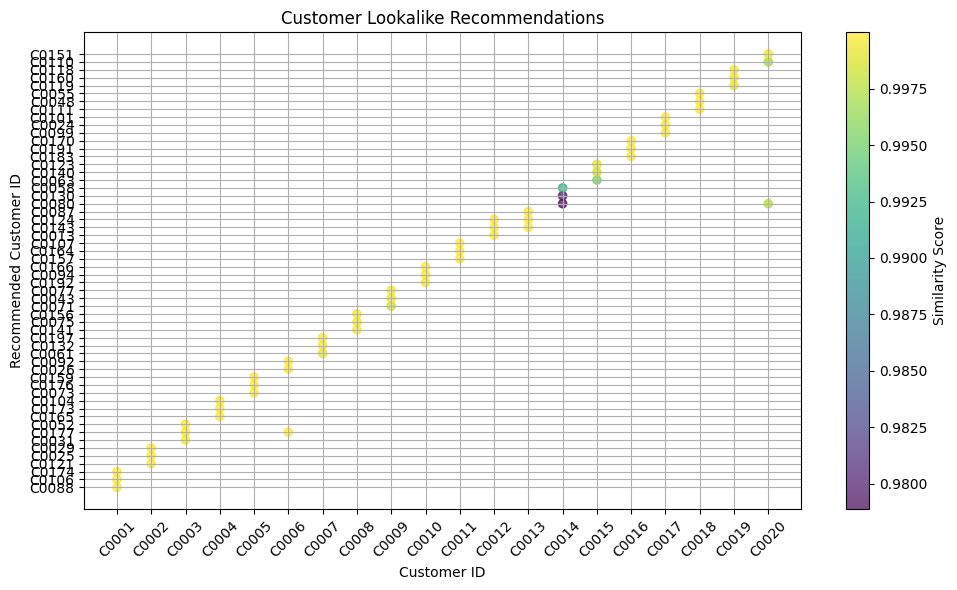

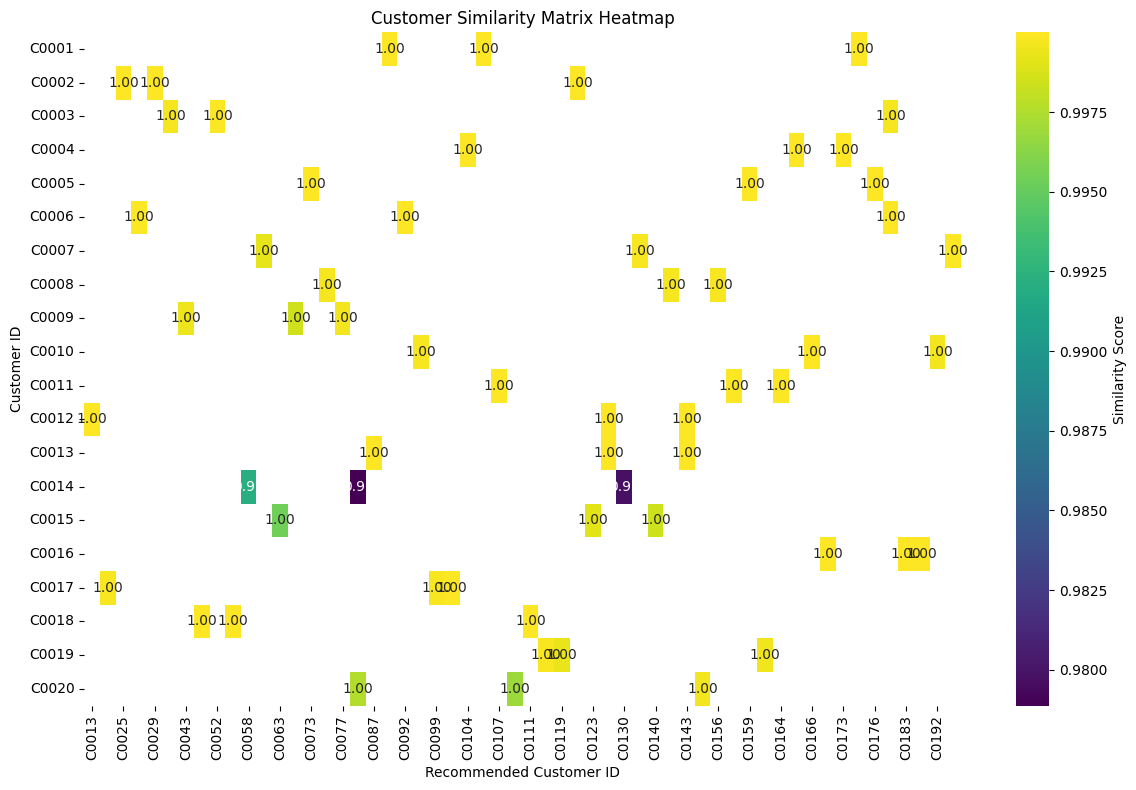

<ipython-input-4-b0268fd1a52a>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RecommendedCustomerID', y='SimilarityScore', data=top_recommendations, palette='viridis')


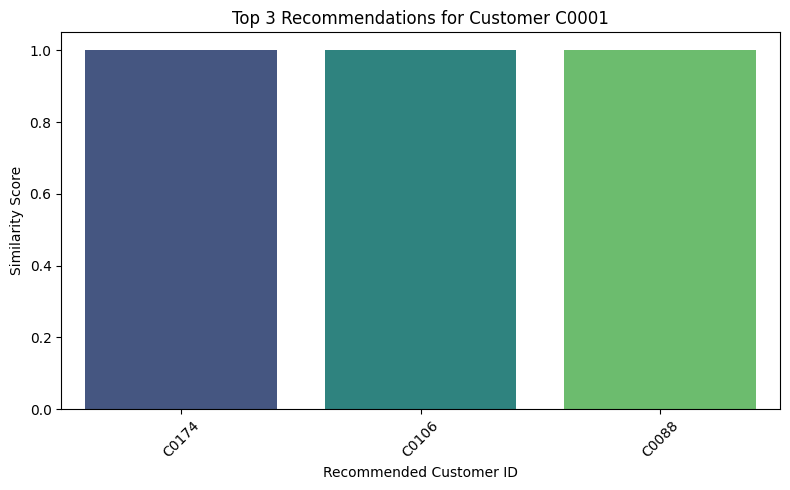

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

recommendations_df = pd.read_csv('Lookalike.csv')

# 1. Scatter Plot of Similarity Scores

plt.figure(figsize=(10, 6))
plt.scatter(recommendations_df['CustomerID'], recommendations_df['RecommendedCustomerID'],
            c=recommendations_df['SimilarityScore'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Similarity Score')
plt.title('Customer Lookalike Recommendations')
plt.xlabel('Customer ID')
plt.ylabel('Recommended Customer ID')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# 2. Heatmap of Similarity Scores for a Subset of Customers

similarity_matrix = recommendations_df.pivot_table(index='CustomerID',
                                                    columns='RecommendedCustomerID',
                                                    values='SimilarityScore')

plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, cmap='viridis', annot=True, fmt=".2f", cbar_kws={'label': 'Similarity Score'})
plt.title('Customer Similarity Matrix Heatmap')
plt.xlabel('Recommended Customer ID')
plt.ylabel('Customer ID')
plt.tight_layout()
plt.show()

# 3. Bar Chart of Top 3 Recommendations for a Specific Customer
specific_customer_id = 'C0001'
top_recommendations = recommendations_df[recommendations_df['CustomerID'] == specific_customer_id].nlargest(3, 'SimilarityScore')

plt.figure(figsize=(8, 5))
sns.barplot(x='RecommendedCustomerID', y='SimilarityScore', data=top_recommendations, palette='viridis')
plt.title(f'Top 3 Recommendations for Customer {specific_customer_id}')
plt.xlabel('Recommended Customer ID')
plt.ylabel('Similarity Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()